<a id="top"></a>
# Look For Transients In FFI's In Nearby Galaxies
***

## Prerequisites
- Basic Python syntax
- Familiarity with types of [extragalactic transients][https://astrobites.org/2022/10/30/guide-to-transient-astronomy/]

## Learning Goals
By the end of this tutorial, you will:

- Maybe something about narrowing down the list of possible targets? Do we want these nearby so they are resolved?
- Use the TESScut feature of astroquery to find a full-frame image time series of a nearby galaxy.
- Use something, lightkurve maybe? to determine if a transient event occured in the galaxy
- Maybe also check if PanSTARRS data is also available - but what to do with it?

## Introduction

Basic draft:
- TESS for searching for exoplanets, but galaxies also contained in the images, can be examined over times.
- Since 2018, TESS has been observing all parts of the sky, with particular overlapping coverage near the ecliptic poles. We will focus on data visible from the Northern hemisphere, so that there may be Pan-STARRS data for further analysis. SO WHICH YEARS NORTHERN DATA
- Transients (link) such as SN so bright (numbers), notable in the time series brightness of the galaxy (are we doing galaxy-integrated counts?)
- 

IS THIS OKAY OR DO WE WANT A SEPARATE TOC SECTION?

The workflow for this notebook consists of:
* [Main Content](#Main-Content)
    * [Loading Data](#Loading-Data)
    * [File and Data Information](#File-and-Data-Information)
* [Visualization](#Visualization)
* [Exercises](#Exercises)
* [Additional Resources](#Additional-Resources)

## Imports

HAVEN'T EDITED YET
Describe the main packages we're using here and their use-case for this notebook. If there's something unusual, explain what the library is, and why we need it.
- *numpy* to handle array functions
- *astropy.io fits* for accessing FITS files
- *astropy.table Table* for creating tidy tables of the data
- *matplotlib.pyplot* for plotting data

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np

from astropy.io import fits
from astropy.table import Table
from astroquery.mast import Mast
from astroquery.mast import Observations

# Added by JRK
from astroquery.mast import Tesscut
from astropy.visualization import time_support
import lightkurve as lk # See if it's on TIKE?

***

In [2]:
# My code that's just playing around for now.
objname = 'M85' # Supernova on June 25th, 2020. https://skyandtelescope.org/astronomy-news/bright-supernovae-light-up-nearby-galaxies/  

sector_table = Tesscut.get_sectors(objectname=objname)
print(sector_table)
# Sector 49 corresponds to Feb 26 - Mar 26, 2022, so would not catch the supernova. How to view sector info by time?
# https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0049-1-1     49      1   1


In [12]:
objname = 'NGC4457' # Supernova on July 1, 2020. 

sector_table = Tesscut.get_sectors(objectname=objname)
print(sector_table)

# Sector 23 was apparently Mar 19 - Apr 15, 2020 - just too early!
# Sector 46 was Dec 02 - Dec 30, 2021 (typo on the website?)
# https://heasarc.gsfc.nasa.gov/docs/tess/sector.html

  sectorName   sector camera ccd
-------------- ------ ------ ---
tess-s0023-1-3     23      1   3
tess-s0046-4-1     46      4   1


Length of hdulist = 2


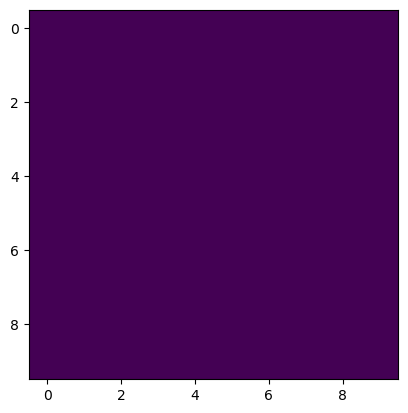

In [15]:
hdulist = Tesscut.get_cutouts(objectname=objname, size=10)
print('Length of hdulist =',len(hdulist))

In [ ]:
hdulist[1].info()
plt.imshow(hdulist[1][2].data)

### Choosing a target galaxy

Loading data and file information should appear within your main content, at the same time the data is going to be used, if possible. These elements of your tutorial can be their own sections within the main content, but avoid generic or vague headings like “Loading Data” and instead use descriptive headings pertinent to the content of the tutorial and the actual data being downloaded or files being used.

If the user needs to download data to run the tutorial properly, where possible, use [astroquery](https://astroquery.readthedocs.io/en/latest/) (or similar) to retrieve files. If this is not possible, see the [data guide](https://github.com/spacetelescope/style-guides/blob/master/guides/where-to-put-your-data.md) for other options.

For example, if we wanted to query for data from MAST for Kepler we might do something like:

In [16]:
keplerObs = Observations.query_criteria(target_name='kplr008957091', obs_collection='Kepler')
keplerProds = Observations.get_product_list(keplerObs[0])
yourProd = Observations.filter_products(keplerProds,extension='kplr008957091-2012277125453_lpd-targ.fits.gz',
                                        mrp_only=False)

### File and Data Information

Where possible (if the code supports it), use code examples that visually display the data in the tutorial. For example, if you are showing an object such as a Table, display a preview of the table:

In [17]:
yourProd[0:5]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str6,str6,str10,str36,str59,str1,str110,str7,str28,str8,str1,str6,str1,str7,str44,int64,str6,str6,int64
549936,Kepler,timeseries,kplr008957091_lc_Q000000000011111111,Target Pixel Long Cadence (TPL) - Q14,C,mast:KEPLER/url/missions/kepler/target_pixel_files/0089/008957091/kplr008957091-2012277125453_lpd-targ.fits.gz,SCIENCE,Minimum Recommended Products,LPD-TARG,--,Kepler,--,GO30032,kplr008957091-2012277125453_lpd-targ.fits.gz,4365449,549936,PUBLIC,2


In [18]:
# Download the products
output = Observations.download_products(yourProd, mrp_only=False, cache=False)
output

Local Path,Status,Message,URL
str103,str8,object,object
./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz,COMPLETE,None,None


Explain pertinent details about the file you've just downloaded. For example, if working with Kepler light curves, explain what's in the different file extensions:

```
- No. 0 (Primary): This HDU contains metadata related to the entire file.
- No. 1 (Light curve): This HDU contains a binary table that holds data like
  flux measurements and times. We will extract information from here when we
  define the parameters for the light curve plot.
- No. 2 (Aperture): This HDU contains the image extension with data collected
  from the aperture. We will also use this to display a bitmask plot that
  visually represents the optimal aperture used to create the SAP_FLUX column in
  HDU1.

```

In [19]:
file = output['Local Path'][0]
print('The HDU list of our output file:\n')
print(fits.info(file))

data = fits.getdata(file, 1)['FLUX']
time = fits.getdata(file, 1)['TIME']

The HDU list of our output file:

Filename: ./mastDownload/Kepler/kplr008957091_lc_Q000000000011111111/kplr008957091-2012277125453_lpd-targ.fits.gz
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   ()      
  1  TARGETTABLES    1 BinTableHDU    287   4757R x 13C   [D, E, J, 64J, 64E, 64E, 64E, 64E, 64E, J, E, E, 40E]   
  2  APERTURE      1 ImageHDU        48   (8, 8)   int32   
None


## Visualization

When presenting any visuals and/or plots from the data, make sure you are using color palettes that are color-blind friendly and using language that keeps accessibility in mind. The most common form of color vision deficiency involves differentiating between red and green, so avoiding colormaps with both red and green will avoid many problems in general. Use descriptive keywords not pertaining to the color of the object you are referring to. It is good practice to make your plots and images large enough to ensure that important details are not hard to see. On the same note, make sure that tick labels, legends, and other plot notations are not too small, and make sure they are descriptive enough that the user can understand what is being represented by the data. 

Let's plot the first four images of the Kepler TPF we just downloaded to see where the center of the PSF is located...

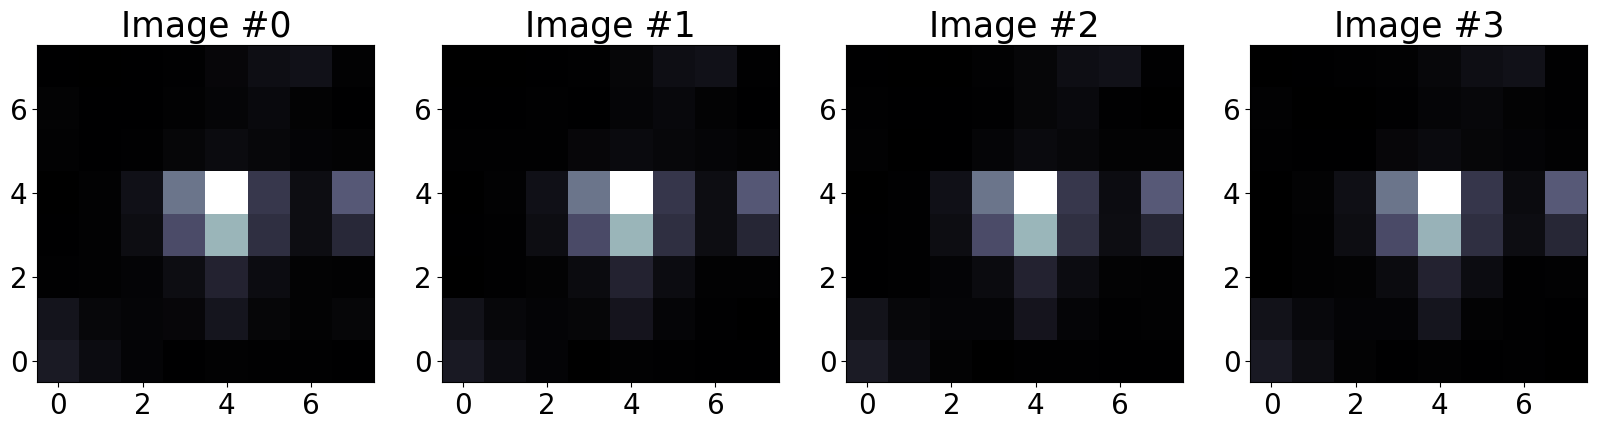

In [20]:
imgs = 4

fig, axs = plt.subplots(1, imgs, figsize=(20, 20))

for idx in range(0, imgs):
    # Plotting
    axs[idx].imshow(data[idx], cmap='bone', origin='lower')
    
    # Formatting
    axs[idx].set_title(f'Image #{idx}', fontsize=25)
    axs[idx].tick_params(axis='both', which='major', labelsize=20)

Looks like it's typically located around (x,y)=(4,4). Let's gather all the images and extract the flux at (4,4) from each of them to patch our lightcurve together...

In [21]:
lightcurve = []

for idx in range(0, len(data)):
    
    flux = data[idx][4, 4]
    lightcurve.append(flux)

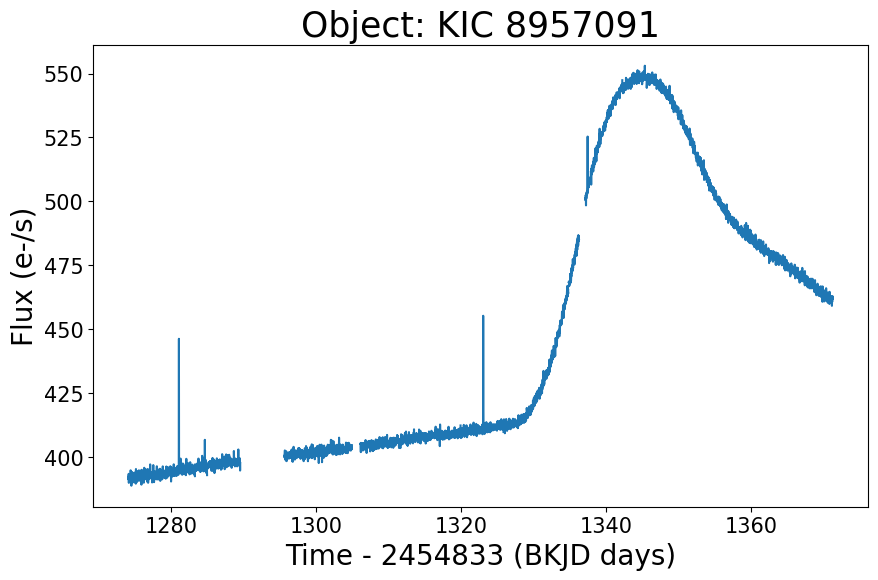

In [22]:
# Plotting
plt.figure(1, figsize=(10, 6))
plt.plot(time, lightcurve)

# Formatting
obj = fits.getheader(file)['OBJECT']
plt.title(f'Object: {obj}', fontsize=25)
plt.xlabel('Time - 2454833 (BKJD days)', fontsize=20)
plt.ylabel('Flux (e-/s)', fontsize=20)
plt.tick_params(axis='both', which='major', labelsize=15)

## Exercises
Exercises are optional, but encouraged. Exercises can be woven into the main content of your tutorial, or appear in their own section toward the end of the tutorial. Final exercises can be more challenging, similar to homework problems. They can be minimal or take as long as 30 minutes to an hour to complete. If you do have one or more exercises in your tutorial, be sure to leave a blank code cell underneath each to show the reader that they're meant to try out their new skill right there. You may also want to include a "solutions" notebook next to your main notebook for the reader to check their work after they have finished their attempt.

## Additional Resources

This section is optional. Try to weave resource links into the main content of your tutorial so that they are falling in line with the context of your writing. For resources that do not fit cleanly into your narrative, you may include an additional resources section at the end of your tutorial. Usually a list of links using Markdown bullet list plus link format is appropriate:

- [MAST API](https://mast.stsci.edu/api/v0/index.html)
- [Kepler Archive Page (MAST)](https://archive.stsci.edu/kepler/)
- [Kepler Archive Manual](https://archive.stsci.edu/kepler/manuals/archive_manual.pdf)
- [Exo.MAST website](https://exo.mast.stsci.edu/)

## Citations

If you use `astropy`, `lightkurve`, or `TESSCut` for published research, please cite the
authors. Follow these links for more information about citing:

* [Citing `astropy`](https://www.astropy.org/acknowledging.html)
* [Citing `lightkurve`](http://docs.lightkurve.org/about/citing.html)
* If you use TESSCut for your work, please cite [Brasseur et al. 2019](https://ui.adsabs.harvard.edu/abs/2019ascl.soft05007B/abstract)

## About this Notebook
**Author(s):** Julia Kamenetzky, ScienceBetter Consultatnt <br>
**Keyword(s):** Tutorial, TIKEBook, TESSCut, FFI, transients, galaxies <br>
**Last Updated:** May 2023 <br>
**Next Review:** Dec 2023
***
[Top of Page](#top)
<img style="float: right;" src="https://raw.githubusercontent.com/spacetelescope/notebooks/master/assets/stsci_pri_combo_mark_horizonal_white_bkgd.png" alt="Space Telescope Logo" width="200px"/> 